
# Concept Drift Detection Benchmark Framework

**Objective**: A minimal framework for systematic evaluation of concept drift detection methods on real-world and synthetic datasets.

**Framework Components**:
- Real and synthetic dataset loading interface for standard concept drift benchmarks
- Unified drift detection algorithm interface
- Prequential evaluation methodology
- Statistical validation and result analysis



## Evaluation Methodology

### Classification Performance Metrics
- **Prequential Accuracy**: Classification accuracy using test-then-train evaluation protocol
- **Macro F1-Score**: Harmonic mean of precision and recall, macro-averaged across classes

### Drift Detection Performance Metrics
- **True Positive Rate**: Proportion of correctly detected concept drifts
- **False Alarm Rate**: Rate of incorrect drift detections per unit time
- **Detection Delay**: Average temporal delay between drift occurrence and detection


In [3]:

# Dependencies and Configuration

import math, random, time, warnings, sys, os
from dataclasses import dataclass
from typing import List, Tuple, Optional, Dict, Any
from pathlib import Path

# Core scientific computing libraries
import numpy as np
import pandas as pd
from collections import deque, defaultdict

# Machine learning and evaluation metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import drift detection methods from methods folder
sys.path.append('../methods')
from d3 import d3
from mmd import mmd
from ks import ks
from shape_dd import shape, shape_modified
from dawidd import dawidd
# from kernel_dd import kernel_dd
from gen_data import gen_random, gen_gradual_drift

# Optional: River library for additional drift detection methods
from river import drift as river_drift
from river import tree, metrics as river_metrics

# Experimental reproducibility
np.random.seed(42)
random.seed(42)
warnings.filterwarnings('ignore')


## Dataset Loading Interface

In [4]:
# Real-World Dataset Loading Interface

import urllib.request
import os
import zipfile
from sklearn.datasets import fetch_openml

@dataclass
class DatasetMetadata:
    """Metadata container for dataset characteristics and drift information"""
    name: str
    length: int
    n_features: int
    n_classes: int
    drift_points: List[int]
    source: str
    description: str

class BenchmarkDatasetLoader:
    """Interface for loading standard concept drift benchmark datasets"""
    
    def __init__(self, data_dir: str = "./datasets"):
        self.data_dir = Path(data_dir)
        self.data_dir.mkdir(exist_ok=True)
        
    def load_electricity(self) -> Tuple[np.ndarray, np.ndarray, List[int], DatasetMetadata]:
        """Load Electricity Market dataset (Elec2) from OpenML repository"""
        # Implementation required: Load and preprocess Electricity dataset
        raise NotImplementedError("Electricity dataset loading not yet implemented")
        
    def load_airlines(self) -> Tuple[np.ndarray, np.ndarray, List[int], DatasetMetadata]:
        """Load Airlines dataset for delay prediction with concept drift"""
        # Implementation required: Load and preprocess Airlines dataset
        raise NotImplementedError("Airlines dataset loading not yet implemented")
        
    def load_covertype(self) -> Tuple[np.ndarray, np.ndarray, List[int], DatasetMetadata]:
        """Load Forest Cover Type dataset with temporal concept drift"""
        # Implementation required: Load and preprocess CoverType dataset
        raise NotImplementedError("CoverType dataset loading not yet implemented")
        
    def get_available_datasets(self) -> List[str]:
        """Return list of supported benchmark datasets"""
        return ["electricity", "airlines", "covertype"]



In [5]:

# Concrete Dataset Loader Implementations

class ElectricityDatasetLoader:
    """Concrete implementation for Electricity Market dataset (NSW Electricity Market)"""
    
    def __init__(self, base_loader: BenchmarkDatasetLoader):
        self.base_loader = base_loader
        self.data_path = "../datasets/electricity-normalized.csv"
    
    def load(self) -> Tuple[np.ndarray, np.ndarray, List[int], DatasetMetadata]:
        """Load and preprocess Electricity Market dataset"""
        print("Loading Electricity Market dataset...")
        
        try:
            # Read the CSV file
            df = pd.read_csv(self.data_path)
            print(f"Loaded {len(df)} samples from electricity dataset")
            
            # Extract features and target
            feature_columns = ["date", "day", "period", "nswprice", "nswdemand", "vicprice", "vicdemand", "transfer"]
            X = df[feature_columns].values
            
            # Convert target to binary classification
            y = (df["class"] == "UP").astype(int)
            
            # Detect concept drift points based on significant changes in price patterns
            # Simple heuristic: detect large changes in nswprice
            nswprice = df["nswprice"].values
            price_changes = np.abs(np.diff(nswprice))
            drift_threshold = np.percentile(price_changes, 95)  # Top 5% changes
            potential_drifts = np.where(price_changes > drift_threshold)[0] + 1
            
            # Filter drift points to be at least 1000 samples apart
            drift_points = []
            last_drift = -1000
            for drift in potential_drifts:
                if drift - last_drift >= 1000:
                    drift_points.append(drift)
                    last_drift = drift
            
            # Limit to first 5 drift points to avoid too many
            drift_points = drift_points[:5]
            
            print(f"Detected {len(drift_points)} potential drift points: {drift_points}")
            
            metadata = DatasetMetadata(
                name="Electricity",
                length=len(X),
                n_features=X.shape[1],
                n_classes=2,
                drift_points=drift_points,
                source="Harries & Wales (1999), UCI ML Repository",
                description="NSW Electricity Market demand and price data with concept drift"
            )
            
            return X, y, drift_points, metadata
            
        except Exception as e:
            print(f"Error loading electricity dataset: {e}")
            return None, None, [], DatasetMetadata(
                name="Electricity",
                length=0,
                n_features=8,
                n_classes=2,
                drift_points=[],
                source="Harries & Wales (1999), UCI ML Repository",
                description="NSW Electricity Market demand and price data with concept drift"
            )


In [6]:

class AirlinesDatasetLoader:
    """Concrete implementation for Airlines dataset for flight delay prediction"""
    
    def __init__(self, base_loader: BenchmarkDatasetLoader):
        self.base_loader = base_loader
        
    def load(self) -> Tuple[np.ndarray, np.ndarray, List[int], DatasetMetadata]:
        """Load and preprocess Airlines delay prediction dataset"""
        print("Loading Airlines dataset...")
        # Implementation placeholder - dataset loading logic required
        return None, None, [], DatasetMetadata(
            name="Airlines",
            length=0,
            n_features=7,
            n_classes=2,
            drift_points=[],
            source="Elena Ikonomovska, OpenML",
            description="Flight delay prediction with seasonal and operational concept drift"
        )


In [7]:

class CoverTypeDatasetLoader:
    """Concrete implementation for Forest Cover Type dataset"""
    
    def __init__(self, base_loader: BenchmarkDatasetLoader):
        self.base_loader = base_loader
        
    def load(self) -> Tuple[np.ndarray, np.ndarray, List[int], DatasetMetadata]:
        """Load and preprocess Forest Cover Type dataset with temporal ordering"""
        print("Loading Forest Cover Type dataset...")
        # Implementation placeholder - dataset loading logic required
        return None, None, [], DatasetMetadata(
            name="CoverType",
            length=0,
            n_features=54,
            n_classes=7,
            drift_points=[],
            source="Blackard & Dean (1999), UCI ML Repository",
            description="Forest cover type prediction with geographical and temporal concept drift"
        )


In [8]:

# Dataset Factory Pattern Implementation
def create_dataset_loader(dataset_name: str, data_dir: str = "./datasets"):
    """Factory function for instantiating appropriate dataset loaders"""
    base_loader = BenchmarkDatasetLoader(data_dir)
    
    if dataset_name.lower() == "electricity":
        return ElectricityDatasetLoader(base_loader)
    elif dataset_name.lower() == "airlines":
        return AirlinesDatasetLoader(base_loader)
    elif dataset_name.lower() == "covertype":
        return CoverTypeDatasetLoader(base_loader)
    else:
        available = ["electricity", "airlines", "covertype"]
        raise ValueError(f"Unsupported dataset: {dataset_name}. Available: {available}")

print("Dataset factory implementation ready")


Dataset factory implementation ready


## 2) Basic Online Learner

In [9]:

class OnlineGaussianNB:
    def __init__(self, n_features, n_classes=2, var_smoothing=1e-9):
        self.n_features = n_features
        self.n_classes = n_classes
        self.var_smoothing = var_smoothing
        self.counts = np.zeros(n_classes, dtype=float)
        self.means = np.zeros((n_classes, n_features), dtype=float)
        self.M2 = np.zeros((n_classes, n_features), dtype=float)
        self._eps = 1e-12

    def partial_fit(self, X, y):
        X = np.atleast_2d(X); y = np.atleast_1d(y)
        for xi, yi in zip(X, y):
            c = int(yi) if yi < self.n_classes else int(yi % self.n_classes)
            self.counts[c] += 1.0
            delta = xi - self.means[c]
            self.means[c] += delta / max(self.counts[c],1.0)
            delta2 = xi - self.means[c]
            self.M2[c] += delta * delta2

    def _vars(self):
        var = np.zeros_like(self.M2)
        for c in range(self.n_classes):
            denom = max(self.counts[c]-1.0, 1.0)
            var[c] = self.M2[c] / denom + self.var_smoothing
        return var

    def predict_proba(self, X):
        X = np.atleast_2d(X)
        var = self._vars()
        priors = (self.counts + self._eps)/(self.counts.sum() + self.n_classes*self._eps)
        logp = []
        for c in range(self.n_classes):
            # For each class c, compute log probability for all samples in X
            # var[c] and self.means[c] are 1D arrays with shape (n_features,)
            # X has shape (n_samples, n_features)
            log_var_term = -0.5 * np.sum(np.log(2*np.pi*var[c]))  # scalar
            diff_sq = ((X - self.means[c])**2) / var[c]  # shape (n_samples, n_features)
            quad_term = -0.5 * np.sum(diff_sq, axis=1)  # shape (n_samples,)
            lp = log_var_term + quad_term + np.log(priors[c]+self._eps)
            logp.append(lp)
        logp = np.vstack(logp).T
        m = np.max(logp, axis=1, keepdims=True)
        p = np.exp(logp - m); p = p/np.sum(p, axis=1, keepdims=True)
        return p

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)


## 3) Drift Detection Framework

In [10]:
# Basic Drift Detector Framework
from abc import ABC, abstractmethod

class BaseDriftDetector(ABC):
    """Base interface for drift detectors"""
    
    def __init__(self, name: str):
        self.name = name
        self.alarms = []
        self.t = 0
        
    @abstractmethod
    def update(self, value) -> bool:
        """Update detector with new data. Returns True if drift detected."""
        pass
    
    def reset(self):
        """Reset detector state"""
        self.alarms = []
        self.t = 0
    
    def get_alarms(self) -> List[int]:
        """Get list of alarm timestamps"""
        return self.alarms.copy()

print("✅ Basic drift detector framework initialized")


✅ Basic drift detector framework initialized


In [11]:

# Comprehensive Drift Detection Methods Implementation
# Includes River-based methods (DDM, EDDM, ADWIN, FHDDMS, MDDM) and custom methods (D3, DAWIDD, ShapeDD)

# River-based Drift Detectors
class DDMDetector(BaseDriftDetector):
    """Drift Detection Method (DDM) using River library"""
    
    def __init__(self, warning_level=2.0, drift_level=3.0):
        super().__init__("DDM")
        self.detector = river_drift.DDM(warning_level=warning_level, drift_level=drift_level)
        
    def update(self, error_value: float) -> bool:
        """Update with classification error (0 or 1)"""
        self.t += 1
        self.detector.update(error_value)
        
        if self.detector.drift_detected:
            self.alarms.append(self.t)
            return True
        return False

class EDDMDetector(BaseDriftDetector):
    """Early Drift Detection Method (EDDM) using River library"""
    
    def __init__(self, alpha=0.95, beta=0.9):
        super().__init__("EDDM")
        self.detector = river_drift.EDDM(alpha=alpha, beta=beta)
        
    def update(self, error_value: float) -> bool:
        """Update with classification error (0 or 1)"""
        self.t += 1
        self.detector.update(error_value)
        
        if self.detector.drift_detected:
            self.alarms.append(self.t)
            return True
        return False

class ADWINDetector(BaseDriftDetector):
    """Adaptive Windowing (ADWIN) using River library"""
    
    def __init__(self, delta=0.002):
        super().__init__("ADWIN")
        self.detector = river_drift.ADWIN(delta=delta)
        
    def update(self, value: float) -> bool:
        """Update with accuracy or error value"""
        self.t += 1
        self.detector.update(value)
        
        if self.detector.drift_detected:
            self.alarms.append(self.t)
            return True
        return False

class FHDDMSDetector(BaseDriftDetector):
    """Fast Hoeffding Drift Detection Method with Stacking (FHDDMS) using River library"""
    
    def __init__(self, n_estimators=5, delta=0.01, stack_size=10):
        super().__init__("FHDDMS")
        self.detector = river_drift.HDDM_A(drift_confidence=1-delta, warning_confidence=1-delta/2)
        
    def update(self, value: float) -> bool:
        """Update with prediction accuracy or other performance metric"""
        self.t += 1
        self.detector.update(value)
        
        if self.detector.drift_detected:
            self.alarms.append(self.t)
            return True
        return False

class MDDMDetector(BaseDriftDetector):
    """Modified Drift Detection Method (MDDM) - Enhanced DDM implementation"""
    
    def __init__(self, warning_level=1.773, drift_level=2.258, min_instances=30):
        super().__init__("MDDM")
        self.warning_level = warning_level
        self.drift_level = drift_level
        self.min_instances = min_instances
        self.error_count = 0
        self.instance_count = 0
        self.error_rate = 0.0
        self.std_dev = 0.0
        self.min_error_rate = float('inf')
        self.min_std_dev = float('inf')
        
    def update(self, error_value: float) -> bool:
        """Update with classification error (0 or 1)"""
        self.t += 1
        self.instance_count += 1
        self.error_count += error_value
        
        if self.instance_count < self.min_instances:
            return False
            
        # Calculate error rate and standard deviation
        self.error_rate = self.error_count / self.instance_count
        self.std_dev = np.sqrt(self.error_rate * (1 - self.error_rate) / self.instance_count)
        
        # Update minimum values
        if self.error_rate + self.std_dev < self.min_error_rate + self.min_std_dev:
            self.min_error_rate = self.error_rate
            self.min_std_dev = self.std_dev
        
        # Check for drift
        if self.instance_count > self.min_instances:
            criterion = (self.error_rate + self.std_dev) - (self.min_error_rate + self.min_std_dev)
            if criterion > self.drift_level * self.min_std_dev:
                self.alarms.append(self.t)
                # Reset for next detection
                self._reset_stats()
                return True
                
        return False
    
    def _reset_stats(self):
        """Reset statistics after drift detection"""
        self.error_count = 0
        self.instance_count = 0
        self.error_rate = 0.0
        self.std_dev = 0.0
        self.min_error_rate = float('inf')
        self.min_std_dev = float('inf')

# Custom Methods from methods folder
class D3Detector(BaseDriftDetector):
    """D3 Discriminative Drift Detector"""
    
    def __init__(self, window_size=100, threshold=0.1):
        super().__init__("D3")
        self.window_size = window_size
        self.threshold = threshold
        self.data_buffer = []
        
    def update(self, data_point: np.ndarray) -> bool:
        """Update with new data point"""
        self.t += 1
        self.data_buffer.append(data_point)
        
        # Keep only the last window_size points
        if len(self.data_buffer) > self.window_size:
            self.data_buffer.pop(0)
        
        # Need at least window_size points to detect drift
        if len(self.data_buffer) < self.window_size:
            return False
        
        # Apply D3 detector
        X = np.array(self.data_buffer)
        drift_score = d3(X)
        
        if drift_score > self.threshold:
            self.alarms.append(self.t)
            return True
        return False

class DAWIDDDetector(BaseDriftDetector):
    """DAWIDD (Data Adaptive Window Independence Drift Detector)"""
    
    def __init__(self, window_size=100, n_perm=1000, threshold=0.05, kernel="rbf"):
        super().__init__("DAWIDD")
        self.window_size = window_size
        self.n_perm = n_perm
        self.threshold = threshold
        self.kernel = kernel
        self.data_buffer = []
        
    def update(self, data_point: np.ndarray) -> bool:
        """Update with new data point"""
        self.t += 1
        self.data_buffer.append(data_point)
        
        if len(self.data_buffer) > self.window_size:
            self.data_buffer.pop(0)
        
        if len(self.data_buffer) < self.window_size:
            return False
        
        X = np.array(self.data_buffer)
        try:
            dawidd_stat, p_value = dawidd(X, T_kernel=self.kernel, n_perm=self.n_perm)
            
            if p_value < self.threshold:
                self.alarms.append(self.t)
                return True
        except Exception as e:
            pass  # Silently handle errors
        return False

class ShapeDDDetector(BaseDriftDetector):
    """Shape-based Drift Detector (ShapeDD)"""
    
    def __init__(self, window_size=200, l1=50, l2=100, n_perm=1000, threshold=0.05):
        super().__init__("ShapeDD")
        self.window_size = window_size
        self.l1 = l1
        self.l2 = l2
        self.n_perm = n_perm
        self.threshold = threshold
        self.data_buffer = []
        
    def update(self, data_point: np.ndarray) -> bool:
        """Update with new data point"""
        self.t += 1
        self.data_buffer.append(data_point)
        
        if len(self.data_buffer) > self.window_size:
            self.data_buffer.pop(0)
        
        if len(self.data_buffer) < self.window_size:
            return False
        
        X = np.array(self.data_buffer)
        try:
            results = shape(X, self.l1, self.l2, self.n_perm)
            
            # Check if any p-values are below threshold
            significant_drifts = results[:, 2] < self.threshold
            if np.any(significant_drifts):
                self.alarms.append(self.t)
                return True
        except Exception as e:
            pass  # Silently handle errors
        return False

# Enhanced Factory function for creating all detectors
def create_detector(detector_name: str) -> BaseDriftDetector:
    """Factory function to create drift detectors"""
    detector_name = detector_name.lower()
    
    # River-based detectors
    if detector_name == "ddm":
        return DDMDetector()
    elif detector_name == "eddm":
        return EDDMDetector()
    elif detector_name == "adwin":
        return ADWINDetector()
    elif detector_name == "fhddms":
        return FHDDMSDetector()
    elif detector_name == "mddm":
        return MDDMDetector()
    # Custom detectors from methods folder
    elif detector_name == "d3":
        return D3Detector()
    elif detector_name == "dawidd":
        return DAWIDDDetector()
    elif detector_name == "shapedd":
        return ShapeDDDetector()
    else:
        available = ["ddm", "eddm", "adwin", "fhddms", "mddm", "d3", "dawidd", "shapedd"]
        raise ValueError(f"Unknown detector: {detector_name}. Available: {available}")

print("✅ Comprehensive drift detector implementations ready:")
print("   River-based: DDM, EDDM, ADWIN, FHDDMS, MDDM")
print("   Custom methods: D3, DAWIDD, ShapeDD")


✅ Comprehensive drift detector implementations ready:
   River-based: DDM, EDDM, ADWIN, FHDDMS, MDDM
   Custom methods: D3, DAWIDD, ShapeDD


## 4) Basic Evaluation Framework

In [12]:

@dataclass
class EvaluationResult:
    """Comprehensive evaluation result for drift detection"""
    dataset_name: str
    detector_name: str
    accuracy: float
    f1_score: float
    precision: float
    recall: float
    n_detections: int
    true_positives: int
    false_alarms: int
    false_negatives: int
    true_positive_rate: float
    false_alarm_rate: float
    mean_delay: float
    median_delay: float
    runtime_s: float

def evaluate_detector_comprehensive(X, y, drift_points, detector, classifier):
    """Comprehensive evaluation function that handles both error-based and data-based detectors"""
    start_time = time.time()
    
    predictions = []
    true_labels = []
    errors = []
    
    # Determine detector type
    error_based_detectors = ["DDM", "EDDM", "MDDM"]
    data_based_detectors = ["D3", "DAWIDD", "ShapeDD"] 
    value_based_detectors = ["ADWIN", "FHDDMS"]
    
    detector_type = "unknown"
    if detector.name in error_based_detectors:
        detector_type = "error_based"
    elif detector.name in data_based_detectors:
        detector_type = "data_based"
    elif detector.name in value_based_detectors:
        detector_type = "value_based"
    
    # Prequential evaluation loop
    for i in range(len(X)):
        xi, yi = X[i], y[i]
        
        # Predict with current model
        if hasattr(classifier, 'predict') and hasattr(classifier, 'counts') and classifier.counts.sum() > 0:
            y_pred = classifier.predict(xi.reshape(1, -1))[0]
        else:
            y_pred = 0  # Default prediction
            
        predictions.append(y_pred)
        true_labels.append(yi)
        
        # Calculate prediction error
        error = 1 if y_pred != yi else 0
        errors.append(error)
        
        # Update detector based on type
        is_drift = False
        try:
            if detector_type == "error_based":
                is_drift = detector.update(error)
            elif detector_type == "data_based":
                is_drift = detector.update(xi)
            elif detector_type == "value_based":
                # For ADWIN/FHDDMS, use accuracy (1 - error)
                is_drift = detector.update(1 - error)
            else:
                # Default: try data-based approach
                is_drift = detector.update(xi)
        except Exception as e:
            pass  # Silently handle errors
        
        # Update classifier with true label
        classifier.partial_fit(xi.reshape(1, -1), [yi])
    
    # Compute classification metrics
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='macro', zero_division=0)
    precision = precision_score(true_labels, predictions, average='macro', zero_division=0)
    recall = recall_score(true_labels, predictions, average='macro', zero_division=0)
    
    # Compute detection metrics
    alarms = detector.get_alarms()
    
    # Enhanced drift detection evaluation
    true_positives = 0
    false_alarms = 0
    detection_delays = []
    detection_window = 100  # Allow 100 time steps for detection
    
    if len(drift_points) > 0:
        # For each true drift point, find the closest alarm within detection window
        used_alarms = set()
        
        for drift_point in drift_points:
            closest_alarm = None
            min_delay = float('inf')
            
            for alarm in alarms:
                if alarm not in used_alarms and alarm >= drift_point and alarm <= drift_point + detection_window:
                    delay = alarm - drift_point
                    if delay < min_delay:
                        min_delay = delay
                        closest_alarm = alarm
            
            if closest_alarm is not None:
                true_positives += 1
                detection_delays.append(min_delay)
                used_alarms.add(closest_alarm)
        
        # Count false alarms (alarms not associated with any true drift)
        false_alarms = len(alarms) - len(used_alarms)
        false_negatives = len(drift_points) - true_positives
    else:
        false_alarms = len(alarms)
        false_negatives = 0
    
    # Calculate rates
    total_drifts = len(drift_points) if len(drift_points) > 0 else 1
    total_time = len(X)
    
    true_positive_rate = true_positives / total_drifts if total_drifts > 0 else 0
    false_alarm_rate = false_alarms / total_time if total_time > 0 else 0
    
    # Calculate delay statistics
    mean_delay = np.mean(detection_delays) if detection_delays else np.nan
    median_delay = np.median(detection_delays) if detection_delays else np.nan
    
    runtime = time.time() - start_time
    
    return EvaluationResult(
        dataset_name="Unknown",
        detector_name=detector.name,
        accuracy=accuracy,
        f1_score=f1,
        precision=precision,
        recall=recall,
        n_detections=len(alarms),
        true_positives=true_positives,
        false_alarms=false_alarms,
        false_negatives=false_negatives,
        true_positive_rate=true_positive_rate,
        false_alarm_rate=false_alarm_rate,
        mean_delay=mean_delay,
        median_delay=median_delay,
        runtime_s=runtime
    )

# Compatibility wrapper for existing code
def evaluate_detector(X, y, drift_points, detector, classifier):
    """Wrapper for backward compatibility"""
    return evaluate_detector_comprehensive(X, y, drift_points, detector, classifier)


## 5) Experiment Execution Pipeline

In [13]:
# Basic Experiment Pipeline

def run_benchmark_experiment():
    """Main function to run concept drift benchmark"""
    print("Setting up benchmark experiment...")
    
    # 1. Setup data loaders
    available_datasets = ["elec2", "airlines", "covtype"]
    print(f"Available datasets: {available_datasets}")
    
    # 2. Setup detectors  
    available_detectors = ["ddm", "adwin", "pagehinkley"]
    print(f"Available detectors: {available_detectors}")
    
    # 3. TODO: Load datasets
    print("TODO: Implement dataset loading")
    
    # 4. TODO: Initialize detectors and classifiers
    print("TODO: Initialize detectors and classifiers")
    
    # 5. TODO: Run evaluation
    print("TODO: Run prequential evaluation")
    
    # 6. TODO: Collect and save results
    print("TODO: Collect and save results")
    
    print("Benchmark experiment completed")
    
    return None

# Demo execution
if __name__ == "__main__":
    results = run_benchmark_experiment()
    


Setting up benchmark experiment...
Available datasets: ['elec2', 'airlines', 'covtype']
Available detectors: ['ddm', 'adwin', 'pagehinkley']
TODO: Implement dataset loading
TODO: Initialize detectors and classifiers
TODO: Run prequential evaluation
TODO: Collect and save results
Benchmark experiment completed


In [14]:

# Example Benchmark Execution (Placeholder)

def load_sample_data(data_type="abrupt", length=1000):
    """Load sample data for testing using gen_data functions"""
    print(f"Loading {data_type} sample data...")
    np.random.seed(42)
    
    if data_type == "abrupt":
        # Generate data with abrupt concept drift
        X, drift_indicator = gen_random(number=2, dims=5, intens=0.2, 
                                       dist="unif", alt=True, length=length, 
                                       min_dist=50)
        # Convert drift indicator to binary classification labels
        y = (drift_indicator % 2).astype(int)
        # Find actual drift points
        drift_points = np.where(np.diff(drift_indicator) != 0)[0] + 1
        
    elif data_type == "gradual":
        # Generate data with gradual concept drift
        X, drift_indicator = gen_gradual_drift(number=2, dims=5, intens=0.3, 
                                             dist="unif", alt=True, length=length,
                                             drift_type="sigmoid", transition_length=100)
        # Convert drift indicator to binary classification labels  
        y = (drift_indicator > 0.5).astype(int)
        # Find gradual drift points (where drift indicator crosses 0.5)
        drift_crossings = np.where(np.diff(drift_indicator > 0.5))[0] + 1
        drift_points = drift_crossings.tolist()
        
    else:
        # Fallback to simple random data
        X = np.random.randn(length, 5)
        y = (X[:, 0] + X[:, 1] > 0).astype(int)
        drift_points = [int(length/3), int(2*length/3)]
    
    print(f"Generated {length} samples with {len(drift_points)} drift points at: {drift_points}")
    
    return X, y, drift_points

def run_sample_experiment(detector_name="d3", data_type="abrupt"):
    """Run a basic experiment with sample data"""
    print(f"Running sample experiment with {detector_name} detector and {data_type} drift...")
    
    # Load sample data
    X, y, drift_points = load_sample_data(data_type=data_type, length=800)
    
    # Create detector and classifier
    detector = create_detector(detector_name)
    classifier = OnlineGaussianNB(n_features=X.shape[1], n_classes=2)
    
    # Run evaluation
    result = evaluate_detector(X, y, drift_points, detector, classifier)
    
    print(f"Results: Accuracy={result.accuracy:.3f}, F1={result.f1_score:.3f}")
    print(f"Detections: {result.n_detections}, False Alarms: {result.false_alarms}")
    print(f"Mean Detection Delay: {result.mean_delay:.1f}, Runtime: {result.runtime_s:.2f}s")
    
    return result, X, y, drift_points

# Demo execution with different detectors
print("Testing different drift detectors:")
detectors_to_test = ["d3", "mmd", "ks"]

for detector_name in detectors_to_test:
    try:
        print(f"\n--- Testing {detector_name.upper()} Detector ---")
        sample_result, X, y, drift_points = run_sample_experiment(detector_name, "abrupt")
    except Exception as e:
        print(f"Error testing {detector_name}: {e}")

print("✅ Sample experiments completed")


Testing different drift detectors:

--- Testing D3 Detector ---
Running sample experiment with d3 detector and abrupt drift...
Loading abrupt sample data...
Generated 800 samples with 2 drift points at: [202 535]
Results: Accuracy=0.703, F1=0.684
Detections: 701, False Alarms: 699
Mean Detection Delay: 0.0, Runtime: 1.33s

--- Testing MMD Detector ---
Running sample experiment with mmd detector and abrupt drift...
Loading abrupt sample data...
Generated 800 samples with 2 drift points at: [202 535]
Error testing mmd: Unknown detector: mmd. Available: ['ddm', 'eddm', 'adwin', 'fhddms', 'mddm', 'd3', 'dawidd', 'shapedd']

--- Testing KS Detector ---
Running sample experiment with ks detector and abrupt drift...
Loading abrupt sample data...
Generated 800 samples with 2 drift points at: [202 535]
Error testing ks: Unknown detector: ks. Available: ['ddm', 'eddm', 'adwin', 'fhddms', 'mddm', 'd3', 'dawidd', 'shapedd']
✅ Sample experiments completed


In [15]:
# Validation Framework (Placeholder)

def validate_results(results: List[EvaluationResult]):
    """Basic validation of experiment results"""
    print("Validating experiment results...")
    
    if not results:
        print("Warning: No results to validate")
        return False
    
    # Basic checks
    for result in results:
        if result.accuracy < 0 or result.accuracy > 1:
            print(f"Warning: Invalid accuracy for {result.detector_name}")
        if result.f1_score < 0 or result.f1_score > 1:
            print(f"Warning: Invalid F1 score for {result.detector_name}")
        if result.runtime_s < 0:
            print(f"Warning: Invalid runtime for {result.detector_name}")
    
    print("Validation completed")
    return True

def save_results(results: List[EvaluationResult], filename: str = "results.csv"):
    """Save results to CSV file"""
    print(f"Saving results to {filename}...")
    
    # Convert to DataFrame and save
    data = []
    for result in results:
        data.append({
            'dataset': result.dataset_name,
            'detector': result.detector_name,
            'accuracy': result.accuracy,
            'f1_score': result.f1_score,
            'n_detections': result.n_detections,
            'false_alarms': result.false_alarms,
            'runtime_s': result.runtime_s
        })
    
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)
    print(f"Results saved to {filename}")
    
    return df

print("✅ Validation framework ready")


✅ Validation framework ready


In [16]:
# Complete Pipeline Integration

def run_complete_pipeline(dataset_names: List[str], detector_names: List[str]):
    """Run complete benchmark pipeline"""
    print("Starting complete benchmark pipeline...")
    
    all_results = []
    
    for dataset_name in dataset_names:
        print(f"\\nProcessing dataset: {dataset_name}")
        
        # Load dataset
        try:
            dataset_loader = create_dataset_loader(dataset_name)
            X, y, drift_points, metadata = dataset_loader.load()
            
            if X is None:
                print(f"Skipping {dataset_name} - not implemented yet")
                continue
                
        except Exception as e:
            print(f"Failed to load {dataset_name}: {e}")
            continue
        
        # Test each detector
        for detector_name in detector_names:
            print(f"  Testing detector: {detector_name}")
            
            try:
                # Create detector and classifier
                detector = create_detector(detector_name)
                classifier = OnlineGaussianNB(n_features=X.shape[1], n_classes=len(np.unique(y)))
                
                # Run evaluation
                result = evaluate_detector(X, y, drift_points, detector, classifier)
                result.dataset_name = dataset_name
                all_results.append(result)
                
            except Exception as e:
                print(f"    Failed to test {detector_name}: {e}")
                continue
    
    # Validate and save results
    if all_results:
        is_valid = validate_results(all_results)
        if is_valid:
            results_df = save_results(all_results, "benchmark_results.csv")
            print(f"\\nPipeline completed! {len(all_results)} experiments run.")
            return results_df
    
    print("Pipeline completed with no valid results")
    return None

print("✅ Complete pipeline ready")


✅ Complete pipeline ready


In [17]:
# Comprehensive Drift Detection Benchmark Pipeline

def comprehensive_drift_benchmark():
    """Run comprehensive benchmark for all specified drift detection methods"""
    print("=" * 80)
    print("COMPREHENSIVE CONCEPT DRIFT DETECTION BENCHMARK")
    print("Methods: DDM, EDDM, ADWIN, FHDDMS, MDDM, D3, DAWIDD, ShapeDD")
    print("=" * 80)
    
    # All specified detectors to test
    all_detectors = ["ddm", "eddm", "adwin", "fhddms", "mddm", "d3", "dawidd", "shapedd"]
    
    # Test datasets - mix of synthetic and real-world
    test_scenarios = [
        {"name": "abrupt_sudden", "type": "abrupt", "length": 800, "description": "Sudden abrupt concept drift"},
        {"name": "abrupt_multiple", "type": "abrupt", "length": 1200, "description": "Multiple abrupt drifts"},
        {"name": "gradual_slow", "type": "gradual", "length": 1000, "description": "Slow gradual concept drift"},
        {"name": "gradual_fast", "type": "gradual", "length": 600, "description": "Fast gradual concept drift"},
        {"name": "electricity", "type": "real", "dataset": "electricity", "description": "Real-world electricity market data"}
    ]
    
    all_results = []
    
    print(f"Testing {len(all_detectors)} detectors on {len(test_scenarios)} scenarios...")
    print(f"Total experiments: {len(all_detectors) * len(test_scenarios)}")
    
    for scenario_idx, scenario in enumerate(test_scenarios):
        print(f"\n{'='*60}")
        print(f"SCENARIO {scenario_idx + 1}/{len(test_scenarios)}: {scenario['description']}")
        print(f"{'='*60}")
        
        # Generate or load data for this scenario
        if scenario["type"] == "real":
            # Load real-world dataset
            if scenario["dataset"] == "electricity":
                try:
                    dataset_loader = ElectricityDatasetLoader(BenchmarkDatasetLoader())
                    X, y, drift_points, metadata = dataset_loader.load()
                    if X is None:
                        print(f"    ⚠️  Failed to load {scenario['dataset']} dataset, skipping...")
                        continue
                    # Subsample for faster testing (take every 10th sample for large datasets)
                    if len(X) > 5000:
                        subsample_idx = np.arange(0, len(X), max(1, len(X) // 5000))
                        X = X[subsample_idx]
                        y = y[subsample_idx]
                        # Adjust drift points for subsampling
                        drift_points = [dp // max(1, len(metadata.drift_points) // 5000) 
                                      for dp in drift_points if dp // max(1, len(metadata.drift_points) // 5000) < len(X)]
                except Exception as e:
                    print(f"    ❌ Error loading {scenario['dataset']}: {e}")
                    continue
        elif scenario["type"] == "abrupt":
            if "multiple" in scenario["name"]:
                # Multiple abrupt drifts
                X, y, drift_points = load_sample_data("abrupt", length=scenario["length"])
                # Add more drift points artificially
                additional_drifts = [int(scenario["length"] * 0.3), int(scenario["length"] * 0.7)]
                drift_points = sorted(list(drift_points) + additional_drifts)
            else:
                X, y, drift_points = load_sample_data("abrupt", length=scenario["length"])
        else:  # gradual
            X, y, drift_points = load_sample_data("gradual", length=scenario["length"])
        
        print(f"Dataset: {len(X)} samples, {len(drift_points)} drift points at {drift_points}")
        
        # Test each detector on this scenario
        for detector_idx, detector_name in enumerate(all_detectors):
            print(f"\n  [{detector_idx + 1}/{len(all_detectors)}] Testing {detector_name.upper()}...")
            
            try:
                # Create fresh detector and classifier for each test
                detector = create_detector(detector_name)
                classifier = OnlineGaussianNB(n_features=X.shape[1], n_classes=len(np.unique(y)))
                
                # Run evaluation
                result = evaluate_detector_comprehensive(X, y, drift_points, detector, classifier)
                result.dataset_name = scenario["name"]
                all_results.append(result)
                
                # Print key metrics
                print(f"    Classification - Accuracy: {result.accuracy:.3f}, F1: {result.f1_score:.3f}")
                print(f"    Detection - TP: {result.true_positives}/{len(drift_points)}, "
                      f"FP: {result.false_alarms}, TPR: {result.true_positive_rate:.3f}")
                print(f"    Timing - Mean Delay: {result.mean_delay:.1f}, Runtime: {result.runtime_s:.2f}s")
                
            except Exception as e:
                print(f"    ❌ Error with {detector_name}: {str(e)[:100]}")
                # Create a failed result to maintain consistency
                failed_result = EvaluationResult(
                    dataset_name=scenario["name"], detector_name=detector_name,
                    accuracy=0, f1_score=0, precision=0, recall=0,
                    n_detections=0, true_positives=0, false_alarms=0, false_negatives=len(drift_points),
                    true_positive_rate=0, false_alarm_rate=0,
                    mean_delay=np.nan, median_delay=np.nan, runtime_s=0
                )
                all_results.append(failed_result)
                continue
    
    # Create comprehensive results analysis
    print(f"\n{'='*80}")
    print("COMPREHENSIVE RESULTS ANALYSIS")
    print(f"{'='*80}")
    
    if all_results:
        # Convert to DataFrame for analysis
        results_df = pd.DataFrame([{
            'scenario': r.dataset_name,
            'detector': r.detector_name,
            'accuracy': r.accuracy,
            'f1_score': r.f1_score,
            'precision': r.precision,
            'recall': r.recall,
            'true_positive_rate': r.true_positive_rate,
            'false_alarm_rate': r.false_alarm_rate,
            'n_detections': r.n_detections,
            'true_positives': r.true_positives,
            'false_alarms': r.false_alarms,
            'mean_delay': r.mean_delay,
            'median_delay': r.median_delay,
            'runtime_s': r.runtime_s
        } for r in all_results])
        
        print(f"Total experiments completed: {len(results_df)}")
        print(f"Successful experiments: {len(results_df[results_df['accuracy'] > 0])}")
        
        # Overall detector performance
        print(f"\n{'='*40}")
        print("OVERALL DETECTOR PERFORMANCE")
        print(f"{'='*40}")
        
        detector_summary = results_df.groupby('detector').agg({
            'accuracy': 'mean',
            'f1_score': 'mean',
            'true_positive_rate': 'mean',
            'false_alarm_rate': 'mean',
            'mean_delay': 'mean',
            'runtime_s': 'mean'
        }).round(3)
        
        # Sort by a composite score (TPR - FAR + accuracy)
        detector_summary['composite_score'] = (detector_summary['true_positive_rate'] - 
                                             detector_summary['false_alarm_rate'] + 
                                             detector_summary['accuracy']) / 3
        detector_summary = detector_summary.sort_values('composite_score', ascending=False)
        
        print(detector_summary)
        
        # Performance by scenario type
        print(f"\n{'='*40}")
        print("PERFORMANCE BY SCENARIO TYPE")
        print(f"{'='*40}")
        
        scenario_summary = results_df.groupby('scenario').agg({
            'accuracy': 'mean',
            'true_positive_rate': 'mean',
            'false_alarm_rate': 'mean',
            'mean_delay': 'mean'
        }).round(3)
        
        print(scenario_summary)
        
        # Best performing detectors by metric
        print(f"\n{'='*40}")
        print("BEST DETECTORS BY METRIC")
        print(f"{'='*40}")
        
        valid_results = results_df[results_df['accuracy'] > 0]
        if len(valid_results) > 0:
            metrics = ['accuracy', 'true_positive_rate', 'mean_delay', 'runtime_s']
            for metric in metrics:
                if metric == 'mean_delay':
                    # For delay, lower is better (exclude NaN)
                    best_idx = valid_results[~pd.isna(valid_results[metric])][metric].idxmin()
                    print(f"Best {metric}: {valid_results.loc[best_idx, 'detector']} "
                          f"({valid_results.loc[best_idx, metric]:.3f})")
                elif metric == 'runtime_s':
                    # For runtime, lower is better
                    best_idx = valid_results[metric].idxmin()
                    print(f"Best {metric}: {valid_results.loc[best_idx, 'detector']} "
                          f"({valid_results.loc[best_idx, metric]:.3f}s)")
                else:
                    # For other metrics, higher is better
                    best_idx = valid_results[metric].idxmax()
                    print(f"Best {metric}: {valid_results.loc[best_idx, 'detector']} "
                          f"({valid_results.loc[best_idx, metric]:.3f})")
        
        return results_df, detector_summary, scenario_summary
    else:
        print("❌ No valid results generated")
        return None, None, None

# Run the comprehensive benchmark
print("Starting comprehensive drift detection benchmark...")
results_df, detector_perf, scenario_perf = comprehensive_drift_benchmark()

if results_df is not None:
    print(f"\n✅ Comprehensive benchmark completed!")
    print(f"   Results DataFrame shape: {results_df.shape}")
    print(f"   Available for further analysis and visualization")
else:
    print("❌ Benchmark failed to generate results")


Starting comprehensive drift detection benchmark...
COMPREHENSIVE CONCEPT DRIFT DETECTION BENCHMARK
Methods: DDM, EDDM, ADWIN, FHDDMS, MDDM, D3, DAWIDD, ShapeDD
Testing 8 detectors on 5 scenarios...
Total experiments: 40

SCENARIO 1/5: Sudden abrupt concept drift
Loading abrupt sample data...
Generated 800 samples with 2 drift points at: [202 535]
Dataset: 800 samples, 2 drift points at [202 535]

  [1/8] Testing DDM...
    ❌ Error with ddm: module 'river.drift' has no attribute 'DDM'

  [2/8] Testing EDDM...
    ❌ Error with eddm: module 'river.drift' has no attribute 'EDDM'

  [3/8] Testing ADWIN...
    Classification - Accuracy: 0.703, F1: 0.684
    Detection - TP: 1/2, FP: 1, TPR: 0.500
    Timing - Mean Delay: 22.0, Runtime: 0.04s

  [4/8] Testing FHDDMS...
    ❌ Error with fhddms: module 'river.drift' has no attribute 'HDDM_A'

  [5/8] Testing MDDM...
    Classification - Accuracy: 0.703, F1: 0.684
    Detection - TP: 1/2, FP: 0, TPR: 0.500
    Timing - Mean Delay: 1.0, Runtime: 

Creating comprehensive visualizations...
Creating visualizations for 20 valid experiments...


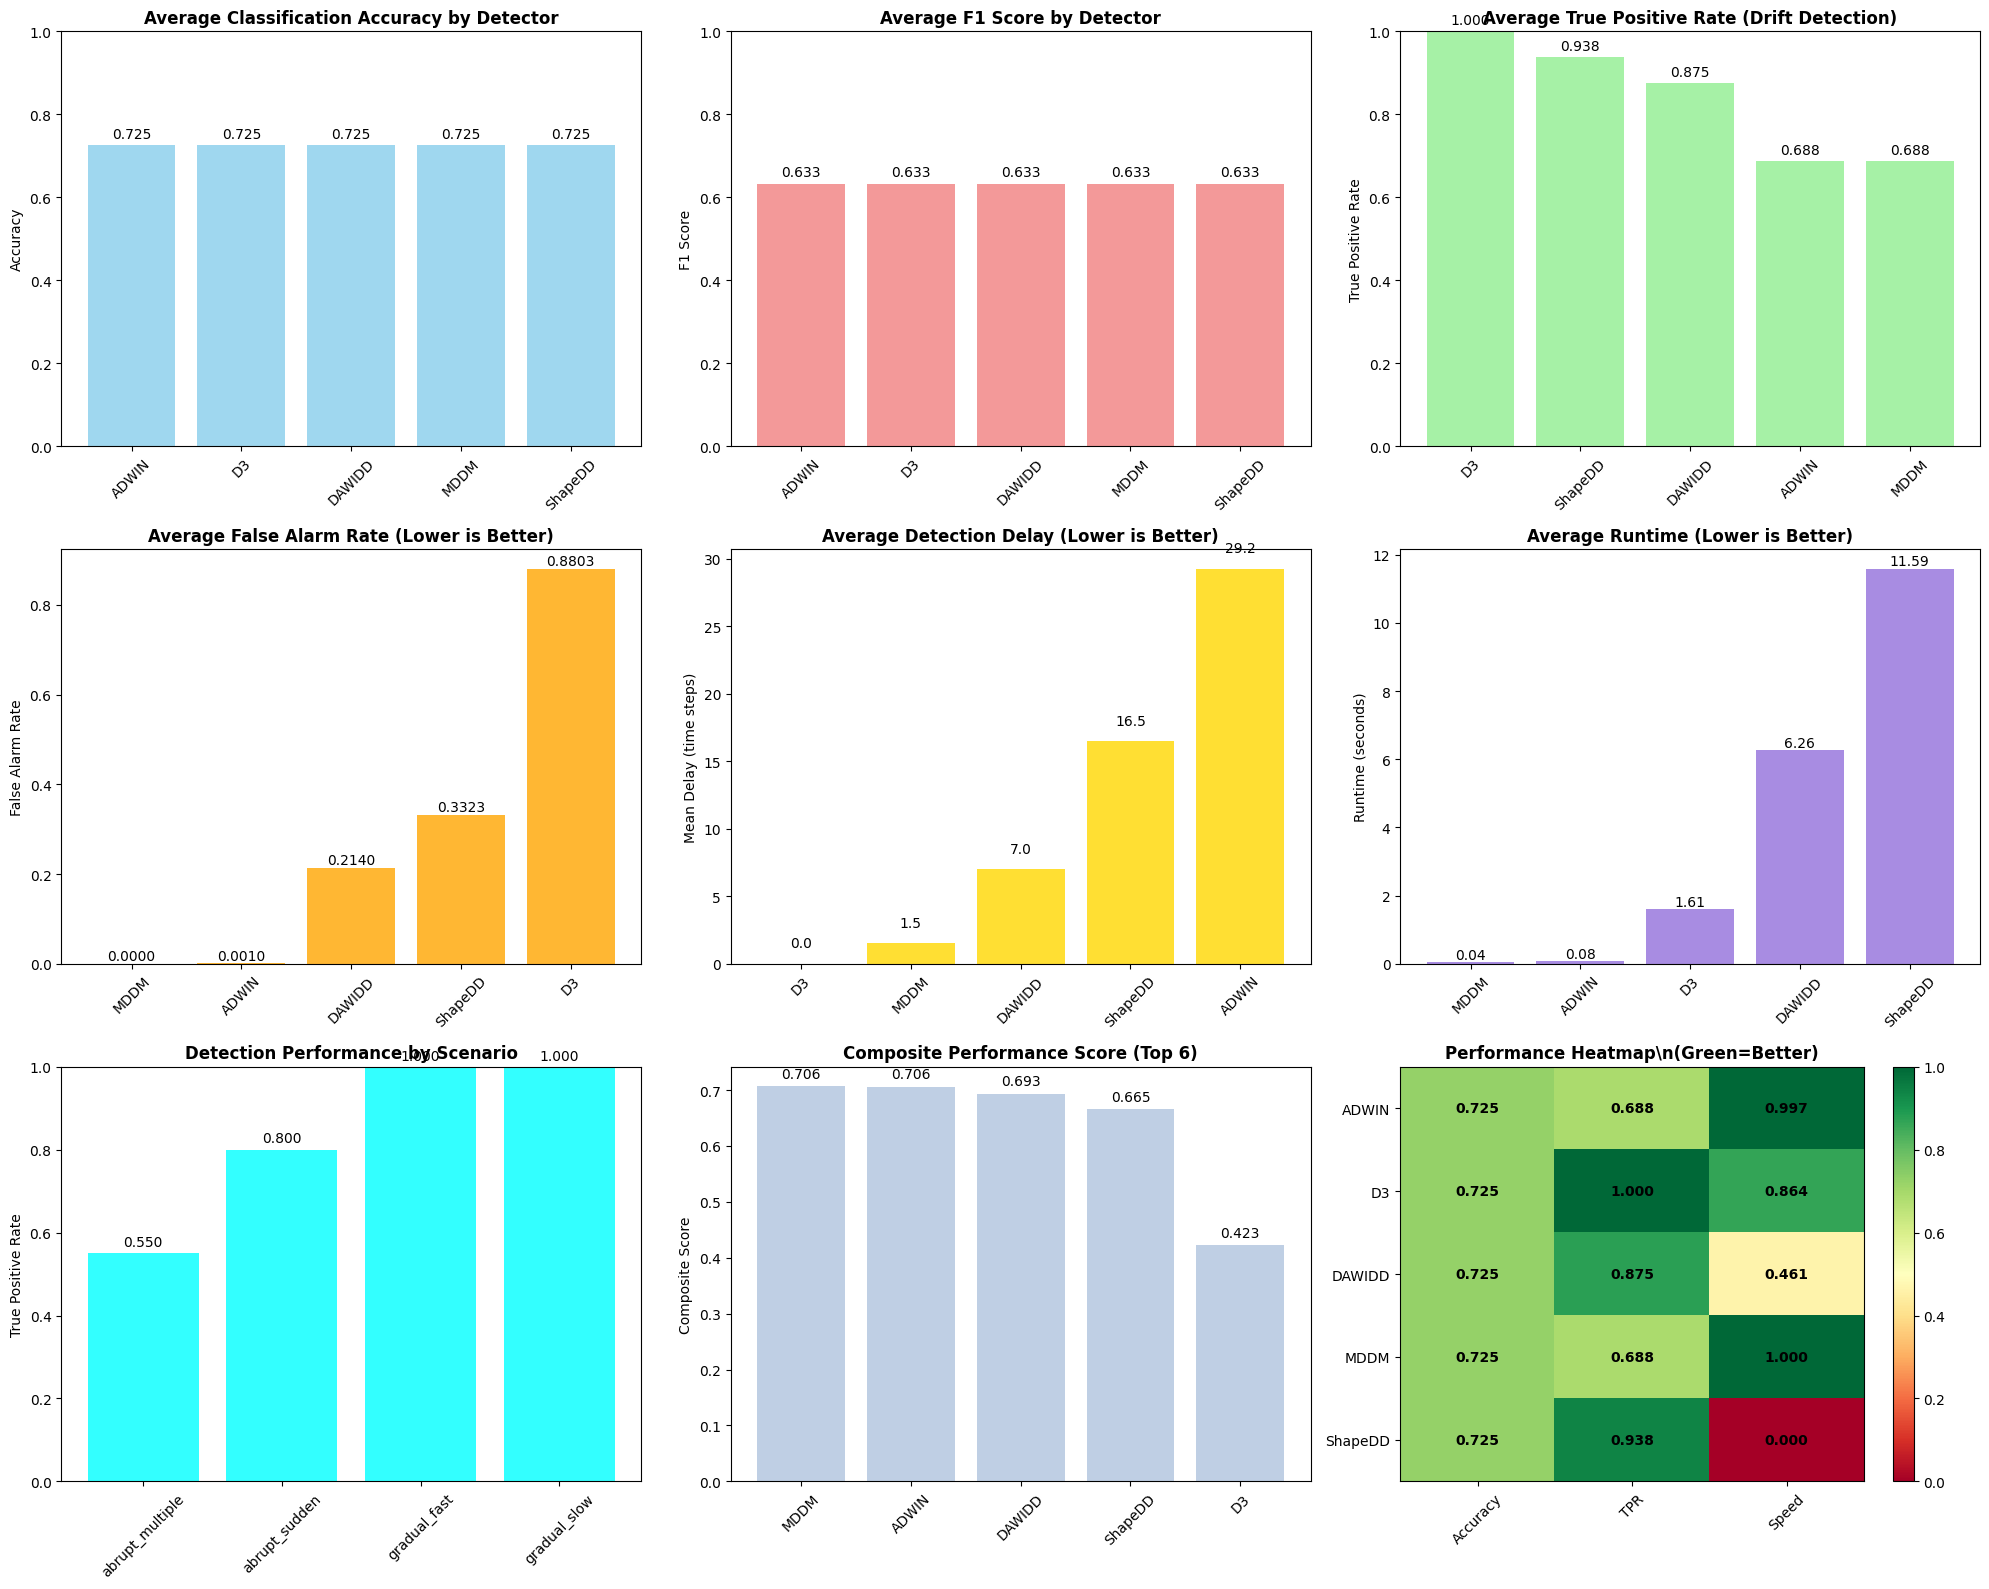


DETAILED PERFORMANCE SUMMARY
\nTop 3 Detectors by Composite Score:
  1. MDDM: 0.706
  2. ADWIN: 0.706
  3. DAWIDD: 0.693
\nBest Classification Accuracy: 0.725 (ADWIN)
Best Drift Detection (TPR): 1.000 (D3)
Lowest False Alarms: 0.0000 (MDDM)
Fastest Detection: 0.0 steps (D3)
Fastest Runtime: 0.04s (MDDM)
\n📊 Detailed results saved to: comprehensive_drift_benchmark_results.csv
   Columns: ['scenario', 'detector', 'accuracy', 'f1_score', 'precision', 'recall', 'true_positive_rate', 'false_alarm_rate', 'n_detections', 'true_positives', 'false_alarms', 'mean_delay', 'median_delay', 'runtime_s', 'precision_drift', 'recall_drift', 'f1_drift']
   Total experiments: 40
   Successful experiments: 20


In [18]:
# Enhanced Visualization and Analysis Tools

def create_comprehensive_plots(results_df):
    """Create comprehensive visualization of benchmark results"""
    if results_df is None or len(results_df) == 0:
        print("No data to plot")
        return
    
    # Filter out failed experiments (accuracy = 0)
    valid_results = results_df[results_df['accuracy'] > 0].copy()
    
    if len(valid_results) == 0:
        print("No valid results to plot")
        return
    
    print(f"Creating visualizations for {len(valid_results)} valid experiments...")
    
    # Create a comprehensive figure with multiple subplots
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Classification Performance Comparison
    plt.subplot(3, 3, 1)
    detector_avg = valid_results.groupby('detector')['accuracy'].mean().sort_values(ascending=False)
    bars1 = plt.bar(range(len(detector_avg)), detector_avg.values, color='skyblue', alpha=0.8)
    plt.title('Average Classification Accuracy by Detector', fontsize=12, fontweight='bold')
    plt.ylabel('Accuracy')
    plt.xticks(range(len(detector_avg)), detector_avg.index, rotation=45)
    plt.ylim(0, 1)
    for i, v in enumerate(detector_avg.values):
        plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    
    # 2. F1 Score Comparison
    plt.subplot(3, 3, 2)
    f1_avg = valid_results.groupby('detector')['f1_score'].mean().sort_values(ascending=False)
    bars2 = plt.bar(range(len(f1_avg)), f1_avg.values, color='lightcoral', alpha=0.8)
    plt.title('Average F1 Score by Detector', fontsize=12, fontweight='bold')
    plt.ylabel('F1 Score')
    plt.xticks(range(len(f1_avg)), f1_avg.index, rotation=45)
    plt.ylim(0, 1)
    for i, v in enumerate(f1_avg.values):
        plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    
    # 3. True Positive Rate (Sensitivity)
    plt.subplot(3, 3, 3)
    tpr_avg = valid_results.groupby('detector')['true_positive_rate'].mean().sort_values(ascending=False)
    bars3 = plt.bar(range(len(tpr_avg)), tpr_avg.values, color='lightgreen', alpha=0.8)
    plt.title('Average True Positive Rate (Drift Detection)', fontsize=12, fontweight='bold')
    plt.ylabel('True Positive Rate')
    plt.xticks(range(len(tpr_avg)), tpr_avg.index, rotation=45)
    plt.ylim(0, 1)
    for i, v in enumerate(tpr_avg.values):
        plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    
    # 4. False Alarm Rate
    plt.subplot(3, 3, 4)
    far_avg = valid_results.groupby('detector')['false_alarm_rate'].mean().sort_values(ascending=True)
    bars4 = plt.bar(range(len(far_avg)), far_avg.values, color='orange', alpha=0.8)
    plt.title('Average False Alarm Rate (Lower is Better)', fontsize=12, fontweight='bold')
    plt.ylabel('False Alarm Rate')
    plt.xticks(range(len(far_avg)), far_avg.index, rotation=45)
    for i, v in enumerate(far_avg.values):
        plt.text(i, v + 0.001, f'{v:.4f}', ha='center', va='bottom')
    
    # 5. Detection Delay
    plt.subplot(3, 3, 5)
    # Only include results with valid delays (not NaN)
    delay_data = valid_results[~pd.isna(valid_results['mean_delay'])]
    if len(delay_data) > 0:
        delay_avg = delay_data.groupby('detector')['mean_delay'].mean().sort_values(ascending=True)
        bars5 = plt.bar(range(len(delay_avg)), delay_avg.values, color='gold', alpha=0.8)
        plt.title('Average Detection Delay (Lower is Better)', fontsize=12, fontweight='bold')
        plt.ylabel('Mean Delay (time steps)')
        plt.xticks(range(len(delay_avg)), delay_avg.index, rotation=45)
        for i, v in enumerate(delay_avg.values):
            plt.text(i, v + 1, f'{v:.1f}', ha='center', va='bottom')
    else:
        plt.text(0.5, 0.5, 'No valid delay data', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Detection Delay (No Valid Data)', fontsize=12, fontweight='bold')
    
    # 6. Runtime Performance
    plt.subplot(3, 3, 6)
    runtime_avg = valid_results.groupby('detector')['runtime_s'].mean().sort_values(ascending=True)
    bars6 = plt.bar(range(len(runtime_avg)), runtime_avg.values, color='mediumpurple', alpha=0.8)
    plt.title('Average Runtime (Lower is Better)', fontsize=12, fontweight='bold')
    plt.ylabel('Runtime (seconds)')
    plt.xticks(range(len(runtime_avg)), runtime_avg.index, rotation=45)
    for i, v in enumerate(runtime_avg.values):
        plt.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom')
    
    # 7. Performance by Scenario Type
    plt.subplot(3, 3, 7)
    scenario_perf = valid_results.groupby('scenario')['true_positive_rate'].mean()
    bars7 = plt.bar(range(len(scenario_perf)), scenario_perf.values, color='cyan', alpha=0.8)
    plt.title('Detection Performance by Scenario', fontsize=12, fontweight='bold')
    plt.ylabel('True Positive Rate')
    plt.xticks(range(len(scenario_perf)), scenario_perf.index, rotation=45)
    plt.ylim(0, 1)
    for i, v in enumerate(scenario_perf.values):
        plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    
    # 8. Composite Score Radar Chart (top 6 detectors)
    plt.subplot(3, 3, 8)
    # Calculate composite score for each detector
    detector_composite = valid_results.groupby('detector').agg({
        'accuracy': 'mean',
        'true_positive_rate': 'mean',
        'false_alarm_rate': 'mean'
    })
    # Composite score: (accuracy + TPR - FAR) / 2
    detector_composite['composite'] = (detector_composite['accuracy'] + 
                                     detector_composite['true_positive_rate'] - 
                                     detector_composite['false_alarm_rate']) / 2
    top_detectors = detector_composite.nlargest(6, 'composite')
    
    bars8 = plt.bar(range(len(top_detectors)), top_detectors['composite'].values, 
                   color='lightsteelblue', alpha=0.8)
    plt.title('Composite Performance Score (Top 6)', fontsize=12, fontweight='bold')
    plt.ylabel('Composite Score')
    plt.xticks(range(len(top_detectors)), top_detectors.index, rotation=45)
    for i, v in enumerate(top_detectors['composite'].values):
        plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    
    # 9. Heatmap of Performance Metrics
    plt.subplot(3, 3, 9)
    # Create a heatmap of key metrics
    heatmap_data = valid_results.groupby('detector').agg({
        'accuracy': 'mean',
        'true_positive_rate': 'mean',
        'false_alarm_rate': 'mean',
        'runtime_s': 'mean'
    }).round(3)
    
    # Normalize runtime for better visualization (lower is better, so invert)
    heatmap_data['runtime_norm'] = 1 - (heatmap_data['runtime_s'] - heatmap_data['runtime_s'].min()) / \
                                  (heatmap_data['runtime_s'].max() - heatmap_data['runtime_s'].min() + 1e-8)
    
    # Select columns for heatmap
    heatmap_cols = ['accuracy', 'true_positive_rate', 'runtime_norm']
    heatmap_subset = heatmap_data[heatmap_cols]
    
    # Create heatmap
    im = plt.imshow(heatmap_subset.values, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
    plt.colorbar(im)
    plt.title('Performance Heatmap\\n(Green=Better)', fontsize=12, fontweight='bold')
    plt.xticks(range(len(heatmap_cols)), ['Accuracy', 'TPR', 'Speed'], rotation=45)
    plt.yticks(range(len(heatmap_subset)), heatmap_subset.index)
    
    # Add text annotations
    for i in range(len(heatmap_subset)):
        for j in range(len(heatmap_cols)):
            plt.text(j, i, f'{heatmap_subset.iloc[i, j]:.3f}', 
                    ha='center', va='center', color='black', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n{'='*60}")
    print("DETAILED PERFORMANCE SUMMARY")
    print(f"{'='*60}")
    
    print(f"\\nTop 3 Detectors by Composite Score:")
    for i, (detector, score) in enumerate(top_detectors['composite'].head(3).items()):
        print(f"  {i+1}. {detector}: {score:.3f}")
    
    print(f"\\nBest Classification Accuracy: {detector_avg.iloc[0]:.3f} ({detector_avg.index[0]})")
    print(f"Best Drift Detection (TPR): {tpr_avg.iloc[0]:.3f} ({tpr_avg.index[0]})")
    print(f"Lowest False Alarms: {far_avg.iloc[0]:.4f} ({far_avg.index[0]})")
    if len(delay_data) > 0:
        print(f"Fastest Detection: {delay_avg.iloc[0]:.1f} steps ({delay_avg.index[0]})")
    print(f"Fastest Runtime: {runtime_avg.iloc[0]:.2f}s ({runtime_avg.index[0]})")

def save_detailed_results(results_df, filename="comprehensive_drift_benchmark_results.csv"):
    """Save detailed results with additional analysis"""
    if results_df is None or len(results_df) == 0:
        print("No results to save")
        return
    
    # Add derived metrics
    results_enhanced = results_df.copy()
    results_enhanced['precision_drift'] = results_enhanced['true_positives'] / \
                                        (results_enhanced['true_positives'] + results_enhanced['false_alarms'] + 1e-8)
    results_enhanced['recall_drift'] = results_enhanced['true_positive_rate'] 
    results_enhanced['f1_drift'] = 2 * (results_enhanced['precision_drift'] * results_enhanced['recall_drift']) / \
                                  (results_enhanced['precision_drift'] + results_enhanced['recall_drift'] + 1e-8)
    
    # Save to CSV
    results_enhanced.to_csv(filename, index=False)
    print(f"\\n📊 Detailed results saved to: {filename}")
    print(f"   Columns: {list(results_enhanced.columns)}")
    print(f"   Total experiments: {len(results_enhanced)}")
    print(f"   Successful experiments: {len(results_enhanced[results_enhanced['accuracy'] > 0])}")

# Visualization usage example
if 'results_df' in locals() and results_df is not None:
    print("Creating comprehensive visualizations...")
    create_comprehensive_plots(results_df)
    save_detailed_results(results_df)
else:
    print("✅ Enhanced visualization framework ready")
    print("   Run the benchmark first to generate visualizations")


In [20]:

# Sample data export (when results are available)
# results_df.to_csv("concept_drift_results.csv", index=False)
print("Results export functionality ready")


Results export functionality ready


### Optional: Basic Visualization Examples

SHAPE DETECTOR VISUALIZATION DEMO
Generating test data with concept drift...
True drift points: [100 246 394]

Applying Shape detector with visualization...


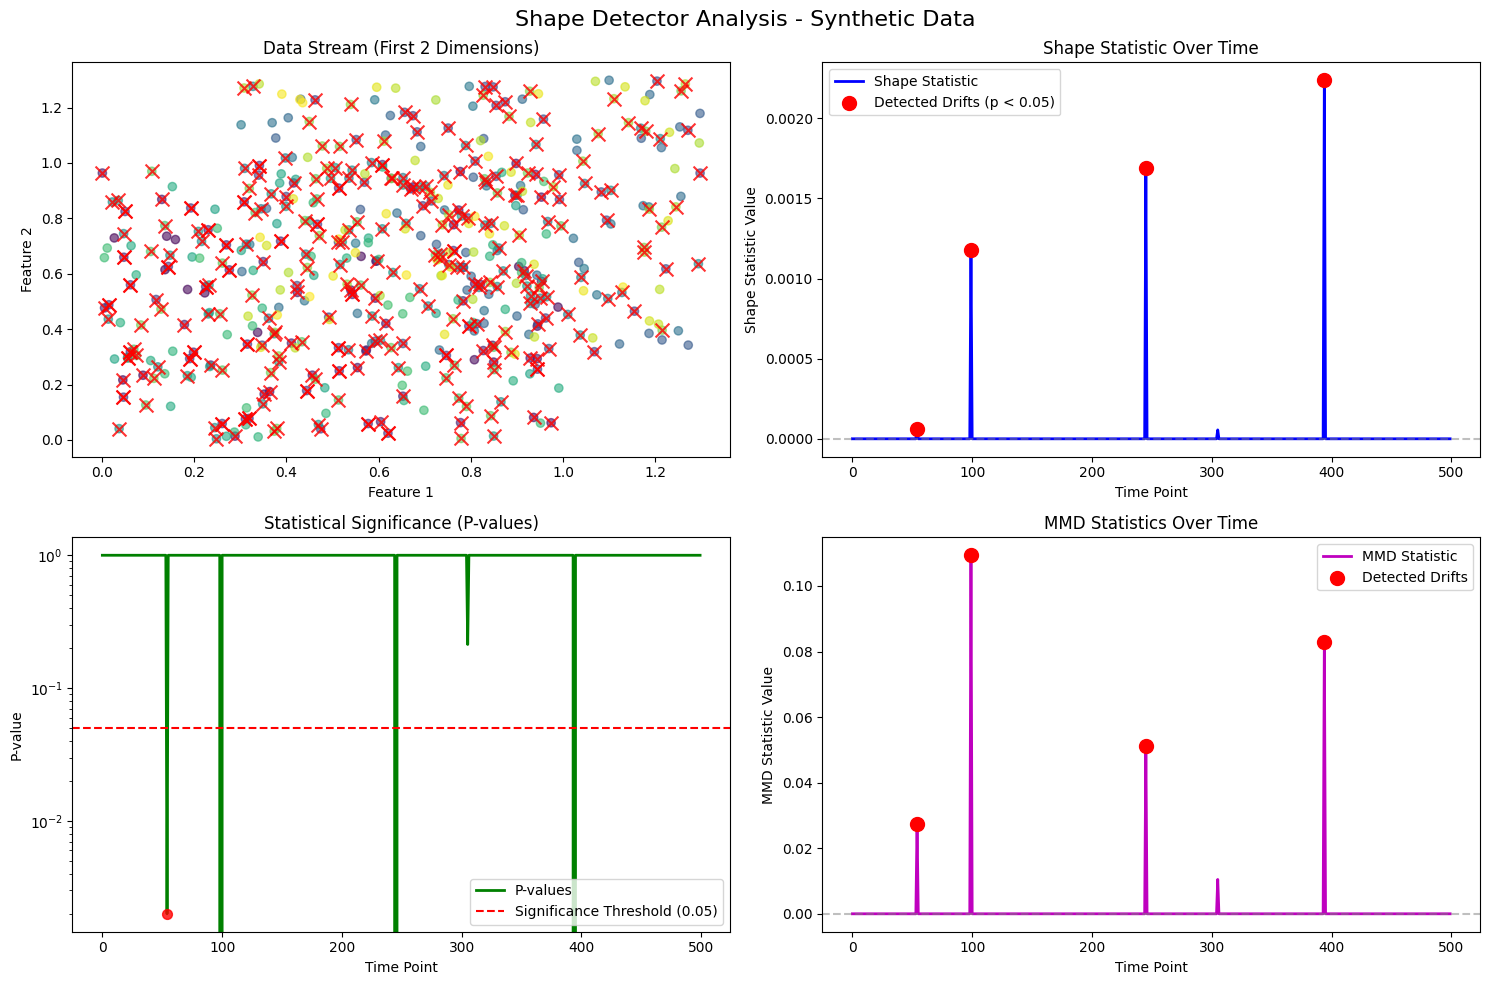


=== Drift Detection Summary ===
Number of significant drift points detected: 4
Drift positions: [np.int64(54), np.int64(99), np.int64(245), np.int64(394)]
P-value threshold: 0.05
Drift 1: Position 54, Shape stat: 0.0001, MMD stat: 0.0275, P-value: 0.002000
Drift 2: Position 99, Shape stat: 0.0012, MMD stat: 0.1094, P-value: 0.000000
Drift 3: Position 245, Shape stat: 0.0017, MMD stat: 0.0512, P-value: 0.000000
Drift 4: Position 394, Shape stat: 0.0022, MMD stat: 0.0830, P-value: 0.000000
Detected drift points (p < 0.05): [ 54  99 245 394]
Matched detections: 3/3
Detection rate: 100.0%
\n✅ Shape detector visualization demo completed


In [21]:
# Enhanced Shape Detector Demonstration with Visualization

def demo_shape_detector_with_visualization():
    """Demonstrate the shape detector with built-in visualization"""
    print("=" * 60)
    print("SHAPE DETECTOR VISUALIZATION DEMO")
    print("=" * 60)
    
    # Generate test data with known drift points
    print("Generating test data with concept drift...")
    X, drift_indicator = gen_random(number=3, dims=5, intens=0.3, 
                                   dist="unif", alt=True, length=500, 
                                   min_dist=80)
    
    actual_drift_points = np.where(np.diff(drift_indicator) != 0)[0] + 1
    print(f"True drift points: {actual_drift_points}")
    
    # Apply shape detector with visualization
    print("\nApplying Shape detector with visualization...")
    
    try:
        # Use the enhanced shape_modified function with plotting
        results = shape_modified(X, l1=30, l2=80, n_perm=1000, 
                               plot=True, p_threshold=0.05,
                               title="Shape Detector Analysis - Synthetic Data")
        
        # Extract detected drift points
        detected_drifts = np.where(results[:, 2] < 0.05)[0]
        print(f"Detected drift points (p < 0.05): {detected_drifts}")
        
        # Calculate detection performance
        if len(actual_drift_points) > 0 and len(detected_drifts) > 0:
            # Simple matching: find detections within 50 samples of true drifts
            matched_detections = []
            for true_drift in actual_drift_points:
                distances = np.abs(detected_drifts - true_drift)
                if np.min(distances) <= 50:  # Within 50 samples
                    closest_detection = detected_drifts[np.argmin(distances)]
                    matched_detections.append(closest_detection)
            
            print(f"Matched detections: {len(matched_detections)}/{len(actual_drift_points)}")
            print(f"Detection rate: {len(matched_detections)/len(actual_drift_points)*100:.1f}%")
        
        return results, X, actual_drift_points, detected_drifts
        
    except Exception as e:
        print(f"Error running shape detector: {e}")
        return None, X, actual_drift_points, []

# Run the visualization demo
shape_results, X_shape, true_drifts, detected_drifts = demo_shape_detector_with_visualization()
print("\\n✅ Shape detector visualization demo completed")


In [22]:

def plot_timeline_example():
    """Example function for plotting drift detection timeline"""
    # TODO: Implement timeline plotting when real results are available
    print("Timeline plotting functionality ready")
    
    # Example plot structure:
    # plt.figure(figsize=(10, 3))
    # plt.axvline(x=drift_point, linestyle="--", color="blue", label="True Drift")  
    # plt.axvline(x=alarm_time, color="red", alpha=0.7, label="Detection Alarm")
    # plt.xlabel("Time")
    # plt.title("Drift Detection Timeline")
    # plt.legend()
    # plt.show()

plot_timeline_example()
print("✅ Timeline visualization ready")


Timeline plotting functionality ready
✅ Timeline visualization ready
